### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.39 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()
            
            
create_sqlit_connection("/",r"lead_scoring_model_experimentation.db")

2.6.0


In [7]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [9]:
# setup pycaret 
from pycaret.classification import setup, compare_models

# Set up PyCaret experiment
model_exp = setup(
    data=dataset,
    target='app_complete_flag',
    fold_shuffle=True,
    session_id=42,
    normalize=True,
    transformation=True,
    ignore_low_variance=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=False,
    ignore_features=[],
    n_jobs=-1,
    use_gpu=True,
    log_experiment=True,
    experiment_name='Lead_scoring_mlflow_production',
    log_plots=True,
    log_data=True,
    silent=True,
    verbose=True,
    log_profile=False
)


,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [10]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']

# Compare models excluding specified ones
best_model = compare_models(
    exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
)

# Output the best model
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7357,0.8145,0.8322,0.6993,0.7600,0.4708,0.4797,4.3190
xgboost,Extreme Gradient Boosting,0.7355,0.8142,0.8293,0.7000,0.7592,0.4704,0.4788,0.5560
et,Extra Trees Classifier,0.7335,0.8116,0.8216,0.7003,0.7561,0.4664,0.4737,2.9990
dt,Decision Tree Classifier,0.7334,0.8110,0.8214,0.7002,0.7560,0.4662,0.4735,0.4010
rf,Random Forest Classifier,0.7318,0.8109,0.8403,0.6922,0.7591,0.4629,0.4741,1.3350
lr,Logistic Regression,0.7174,0.7838,0.8169,0.6831,0.7440,0.4342,0.4429,0.2020
ridge,Ridge Classifier,0.7166,0.0000,0.8258,0.6795,0.7455,0.4324,0.4430,0.3580
lda,Linear Discriminant Analysis,0.7166,0.7835,0.8258,0.6795,0.7455,0.4324,0.4430,3.8360
nb,Naive Bayes,0.6611,0.7268,0.8713,0.6151,0.7211,0.3206,0.3533,0.1420


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [11]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

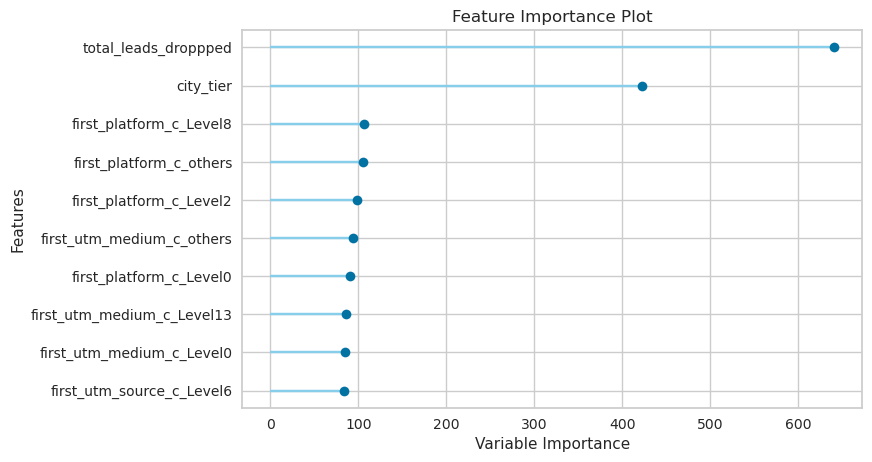

In [12]:
# create feature importance plot
plot_model(lgbm, plot='feature')


### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [13]:
dataset.columns

Index(['city_tier', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c', 'total_leads_droppped', 'referred_lead',
       'app_complete_flag', 'assistance_interaction', 'career_interaction',
       'payment_interaction', 'social_interaction', 'syllabus_interaction'],
      dtype='object')

In [14]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.


# Select only the required features for modeling
selected_features = ['total_leads_droppped', 'city_tier', 'referred_lead', 
                     'app_complete_flag', 'first_platform_c', 
                     'first_utm_medium_c', 'first_utm_source_c']

# Filter the dataset to include only the selected features
data = dataset[selected_features]

# Set up PyCaret experiment
model_exp = setup(
    data=data,
    target='app_complete_flag',
    fold_shuffle=True,
    session_id=42,
    normalize=False,
    transformation=False,
    ignore_low_variance=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=False,
    ignore_features=[],
    n_jobs=-1,
    use_gpu=True,
    log_experiment=True,
    experiment_name='Lead_scoring_mlflow_production',
    log_plots=True,
    log_data=True,
    silent=True,
    verbose=True,
    log_profile=False
)


,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada'].

# Compare models excluding specified ones
best_model = compare_models(
    exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
)

# Output the best model
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7357,0.8145,0.8322,0.6993,0.7600,0.4708,0.4797,4.5270
xgboost,Extreme Gradient Boosting,0.7355,0.8142,0.8293,0.7000,0.7592,0.4704,0.4788,0.4900
dt,Decision Tree Classifier,0.7334,0.8111,0.8215,0.7002,0.7560,0.4662,0.4735,0.4350
et,Extra Trees Classifier,0.7334,0.8116,0.8216,0.7002,0.7561,0.4664,0.4736,2.9580
rf,Random Forest Classifier,0.7322,0.8113,0.8398,0.6928,0.7592,0.4637,0.4747,1.2910
lr,Logistic Regression,0.7072,0.7757,0.8183,0.6713,0.7376,0.4136,0.4241,0.1490
ridge,Ridge Classifier,0.6957,0.0000,0.7963,0.6648,0.7246,0.3907,0.3987,0.2420
lda,Linear Discriminant Analysis,0.6957,0.7623,0.7963,0.6648,0.7246,0.3907,0.3987,1.1140
nb,Naive Bayes,0.6614,0.7220,0.8707,0.6154,0.7211,0.3211,0.3535,0.1440


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [16]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm_model = create_model('lightgbm')

In [17]:
!pip install optuna
!pip install --upgrade optuna optuna-integration

  Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
  Using cached optuna_integration-3.6.0-py3-none-any.whl (93 kB)


In [18]:

# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
from optuna.distributions import IntDistribution

lgbm_params = {
    'num_leaves': IntDistribution(20, 50),
    # Add other hyperparameters with their respective distributions...
}

# Tune the LightGBM model
tuned_lgbm_optuna,tuner_2 = tune_model(lgbm_model, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    custom_grid=lgbm_params,
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

# Finalize the tuned model
final_lgbm_model = finalize_model(tuned_lgbm_optuna)


In [19]:
# Print the final models configuration so that we can use it in the model retraining pipeline
model_config = final_lgbm_model.get_params()
model_config

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 41,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'gpu'}

In [21]:
mlflow.lightgbm.log_model(final_lgbm_model, "LightGBM model")

ModelInfo(artifact_path='LightGBM model', flavors={'python_function': {'loader_module': 'mlflow.lightgbm', 'python_version': '3.8.12', 'data': 'model.pkl', 'env': 'conda.yaml'}, 'lightgbm': {'lgb_version': '3.3.2', 'data': 'model.pkl', 'model_class': 'lightgbm.sklearn.LGBMClassifier', 'code': None}}, model_uri='runs:/0fb3339aab624990b2e0707504914838/LightGBM model', model_uuid='48173d0914744c5794c7ebca4e988c31', run_id='0fb3339aab624990b2e0707504914838', saved_input_example_info=None, signature_dict=None, utc_time_created='2024-08-22 09:10:17.631510', mlflow_version='1.26.1')